/var/folders/zl/bx0xnm592yx0_t83nj9_8nvm0000gp/T/ipykernel_353/3503908491.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.set_index('timestamp').resample('1H').mean().reset_index()


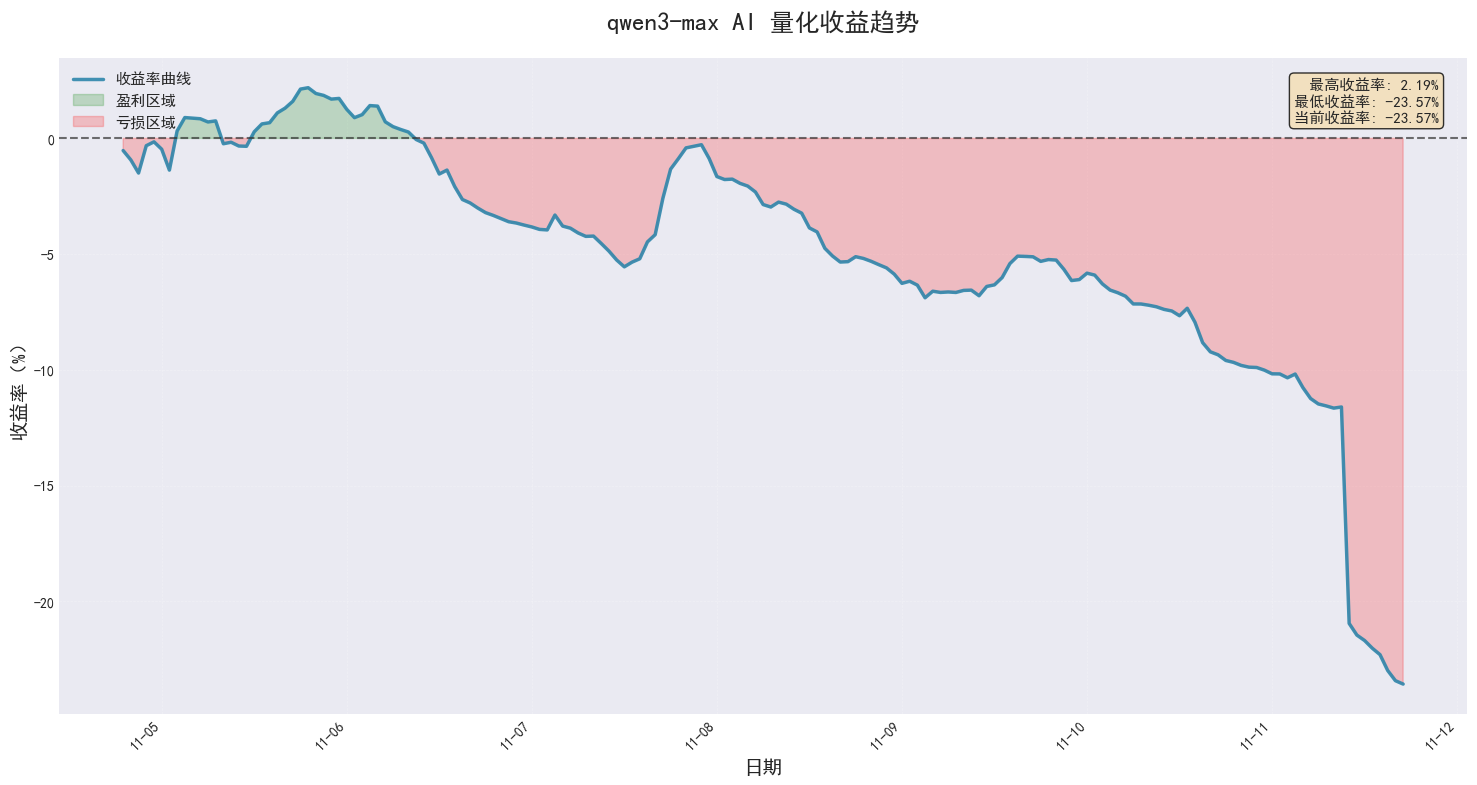


=== 收益统计 ===
初始资金: ¥30,000.00
当前资金: ¥22,928.88
最高收益率: 2.19%
最低收益率: -23.57%
当前收益率: -23.57%
波动率: 5.27%


In [5]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# 先清除缓存并重新加载字体
import matplotlib
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 连接数据库
conn = sqlite3.connect('AITradeGame.db')

df = pd.read_sql_query('''
    SELECT timestamp, total_value, model_id 
    FROM account_values 
    ORDER BY timestamp
''', conn)

conn.close()

# 转换 timestamp 为 datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 计算收益百分比
initial_value = 30000
df['return_pct'] = (df['total_value'] - initial_value) / initial_value * 100

# 降采样：每小时取一个点
df_resampled = df.set_index('timestamp').resample('1H').mean().reset_index()

# 绘制图表
fig, ax = plt.subplots(figsize=(16, 8))

# 绘制收益率曲线
line = ax.plot(df_resampled['timestamp'], df_resampled['return_pct'], 
               linewidth=2.5, color='#2E86AB', label='收益率曲线', alpha=0.9)

# 填充正负收益区域
ax.fill_between(df_resampled['timestamp'], df_resampled['return_pct'], 0, 
                where=(df_resampled['return_pct'] >= 0), 
                interpolate=True, alpha=0.2, color='green', label='盈利区域')
ax.fill_between(df_resampled['timestamp'], df_resampled['return_pct'], 0, 
                where=(df_resampled['return_pct'] < 0), 
                interpolate=True, alpha=0.2, color='red', label='亏损区域')

# 添加 0% 基准线
ax.axhline(y=0, color='#333333', linestyle='--', linewidth=1.5, alpha=0.7)

# 设置标题和标签
ax.set_xlabel('日期', fontsize=14, fontweight='bold')
ax.set_ylabel('收益率（%）', fontsize=14, fontweight='bold')
ax.set_title('qwen3-max AI 量化收益趋势', fontsize=18, fontweight='bold', pad=20)

# 格式化 x 轴日期 - 每天都显示
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # 每1天显示一个刻度
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 添加网格
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# 添加图例
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

# 添加统计信息文本框
max_return = df_resampled['return_pct'].max()
min_return = df_resampled['return_pct'].min()
final_return = df_resampled['return_pct'].iloc[-1]

stats_text = f'最高收益率: {max_return:.2f}%\n最低收益率: {min_return:.2f}%\n当前收益率: {final_return:.2f}%'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 调整布局
fig.subplots_adjust(bottom=0.12, top=0.94, left=0.08, right=0.96)

plt.show()

# 打印详细统计信息
print(f"\n=== 收益统计 ===")
print(f"初始资金: ¥{initial_value:,.2f}")
print(f"当前资金: ¥{df_resampled['total_value'].iloc[-1]:,.2f}")
print(f"最高收益率: {max_return:.2f}%")
print(f"最低收益率: {min_return:.2f}%")
print(f"当前收益率: {final_return:.2f}%")
print(f"波动率: {df_resampled['return_pct'].std():.2f}%")